In [185]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, plot_importance
import sqlite3 as lite
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [251]:
con = lite.connect('./data/src/diamonds_train.db/diamonds_train.db')

In [252]:
cursor = con.cursor()

In [253]:
raw_df = pd.read_sql('''SELECT *
FROM diamonds_transactional dt JOIN diamonds_dimensions ddi 
		ON dt.index_id = ddi.index_id 
	JOIN diamonds_properties dp ON dp.index_id = dt.index_id 
	JOIN diamonds_cut dc ON dc.cut_id = dp.cut_id 
	JOIN diamonds_color dc2 ON dc2.color_id = dp.color_id 
	JOIN diamonds_clarity dc3 ON dc3.clarity_id = dp.clarity_id 
	JOIN diamonds_city dc4 ON dc4.city_id = dt.city_id;''', con )

In [254]:
raw_df

,index_id,price,city_id,carat,index_id,depth,table,x,y,z,...,color_id,clarity_id,cut_id,cut,color_id,color,clarity_id,clarity,city_id,city
0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,4268,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,1.21,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,62.4,58.0,6.83,6.79,4.25,...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,de88c121a82a06352bf1aaceba20578356408a334ba046...,Premium,6da43b944e494e885e69af021f93c6d9331c78aa228084...,J,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,VS2,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,Dubai
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,505,89c7286890f7347ab235234e74d406596a127ae3679042...,0.32,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,63.0,57.0,4.35,4.38,2.75,...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,Very Good,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,H,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,VS2,89c7286890f7347ab235234e74d406596a127ae3679042...,Kimberly
2,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,2686,2bd25cd960aba8b706e2b67f2bb38b750ee5384b0e9883...,0.71,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,65.5,55.0,5.62,5.53,3.65,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,Fair,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,VS1,2bd25cd960aba8b706e2b67f2bb38b750ee5384b0e9883...,Las Vegas
3,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,738,89c7286890f7347ab235234e74d406596a127ae3679042...,0.41,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,63.8,56.0,4.68,4.72,3.00,...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,Good,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,D,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,SI1,89c7286890f7347ab235234e74d406596a127ae3679042...,Kimberly
4,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,4882,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,1.02,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,60.5,59.0,6.55,6.51,3.95,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,Ideal,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,SI1,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,f0bc79169405ebeb24e308055156b946ffd819db9b4f75...,10070,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,1.34,f0bc79169405ebeb24e308055156b946ffd819db9b4f75...,62.7,57.0,7.10,7.04,4.43,...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,Ideal,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,G,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,VS1,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,Antwerp
40451,339916a23bf22b052b54cb2a9b36ee8418c1c68b46acad...,12615,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.02,339916a23bf22b052b54cb2a9b36ee8418c1c68b46acad...,57.1,60.0,8.31,8.25,4.73,...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,Good,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,F,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,SI2,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,Madrid
40452,46957922b99954654c1deb8d854c3f069bf118b2ce9415...,5457,89c7286890f7347ab235234e74d406596a127ae3679042...,1.01,46957922b99954654c1deb8d854c3f069bf118b2ce9415...,62.7,56.0,6.37,6.42,

In [255]:
raw_df.describe()

,price,carat,depth,table,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154
std,3992.416147,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


In [256]:
test['color'].describe()

count    13485.000000
mean         4.420912
std          1.700614
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          7.000000
Name: color, dtype: float64

In [257]:
raw_df.columns

Index(['index_id', 'price', 'city_id', 'carat', 'index_id', 'depth', 'table',
       'x', 'y', 'z', 'index_id', 'cut_id', 'color_id', 'clarity_id', 'cut_id',
       'cut', 'color_id', 'color', 'clarity_id', 'clarity', 'city_id', 'city'],
      dtype='object')

In [258]:
clean_df = raw_df[ ['price', 'carat',  'depth', 'table','x', 'y', 'z','cut', 'color', 'clarity', 'city']]

In [259]:
clean_df.to_csv('./data/clean/clean.csv')
clean_df

,price,carat,depth,table,x,y,z,cut,color,clarity,city
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,Dubai
1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,Kimberly
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,Las Vegas
3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,Kimberly
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,Dubai
...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,62.7,57.0,7.10,7.04,4.43,Ideal,G,VS1,Antwerp
40451,12615,2.02,57.1,60.0,8.31,8.25,4.73,Good,F,SI2,Madrid
40452,5457,1.01,62.7,56.0,6.37,6.42,4.01,Ideal,H,SI1,Kimberly
40453,456,0.33,61.9,54.3,4.45,4.47,2.76,Ideal,J,VS1,Kimberly


In [260]:
def data_labeling(df, cols):
   dic = {}
   for col in cols:
      group_by = df[[col,'price']].groupby(col).median().sort_values('price')
      for key in group_by.index:
         dic[key] = sorted(list(group_by['price'])).index(group_by.loc[key,'price']) + 1
      print(dic)
      for key,value in dic.items():
         df.loc[df[col] == key,col] = value
      df[col] = df[col].astype(float)
   return dic


In [261]:
def data_labeling_test(df, cols, dic):
   for col in cols:
      for key,value in dic.items():
         df.loc[df[col] == key,col] = value
      df[col] = df[col].astype(float)


In [262]:
#dic = data_labeling(clean_df, ['cut', 'color', 'clarity','city'])
#dic

In [263]:
dic2 = {'Ideal': 5,
 'Very Good': 3,
 'Good': 2,
 'Premium': 4,
 'Fair': 1,
 'E': 6,
 'D': 7,
 'G': 4,
 'F': 5,
 'H': 3,
 'I': 2,
 'J': 1,
 'IF': 8,
 'VVS1': 7,
 'VVS2': 6,
 'VS1': 5,
 'VS2': 4,
 'SI1': 3,
 'I1': 1,
 'SI2': 2,
 'Paris': 1.0,
 'Luxembourg': 1.0017263703064307,
 'Tel Aviv': 1.0051791109192922,
 'Zurich': 1.0310746655157532,
 'London': 1.0332326283987916,
 'Antwerp': 1.0358221838584376,
 'Madrid': 1.0360379801467414,
 'Las Vegas': 1.0388433318946915,
 'Surat': 1.0401381096245144,
 'New York City': 1.048769961156668,
 'Amsterdam': 1.0548122572291756,
 'Kimberly': 1.0561070349589987,
 'Dubai': 1.0699179974104445}

In [264]:
#data_labeling(clean_df, ['cut', 'color', 'clarity','city'])
data_labeling_test(clean_df, ['cut', 'color', 'clarity','city'],dic2)
#clean_df = pd.concat([clean_df, pd.get_dummies(clean_df[['cut', 'color', 'clarity','city']], drop_first=True)], axis = 1).drop(['cut', 'color', 'clarity','city'],axis = 1)


/tmp/ipykernel_31332/1822649115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/tmp/ipykernel_31332/1822649115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/tmp/ipykernel_31332/1822649115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [265]:
clean_df.describe()

,price,carat,depth,table,x,y,z,cut,color,clarity,city
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154,3.904783,4.400766,4.049388,1.036433
std,3992.416147,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062,1.117876,1.701260,1.648181,0.019357
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000,5.000000,7.000000,8.000000,1.069918


In [266]:
def sub_outlyers(df,deviations):
    df2 = df.copy()
    for col in df.columns:
        min = df[col].mean() - deviations * df[col].std()
        max = df[col].mean() + deviations * df[col].std()
        df2.loc[df[col] < min,col] = min    
        df2.loc[df[col] > max,col] = max
    return df2

In [267]:
outlier_columns = ['carat','depth','table', 'x', 'y', 'z']
clean_df[outlier_columns] = sub_outlyers(clean_df[outlier_columns],3)
clean_df.describe()

/tmp/ipykernel_31332/3379422112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[outlier_columns] = sub_outlyers(clean_df[outlier_columns],3)


,price,carat,depth,table,x,y,z,cut,color,clarity,city
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.795712,61.749087,57.433731,5.729428,5.731641,3.537474,3.904783,4.400766,4.049388,1.036433
std,3992.416147,0.468168,1.361600,2.176820,1.122433,1.114376,0.693746,1.117876,1.701260,1.648181,0.019357
min,326.000000,0.200000,57.457665,50.745527,2.356034,2.292869,1.445969,1.000000,1.000000,1.000000,1.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770
max,18823.000000,2.224338,66.048018,64.146739,9.102750,9.172768,5.628338,5.000000,7.000000,8.000000,1.069918


In [268]:
def feature_xy(x,y):
    try:
        return x/y
    except:
        return 1
    
def feature_ad(carat,x,y,z,):
    try:
        return carat/(x*y*z)
    except:
        return 1


In [269]:
clean_df['x/y'] = clean_df.apply(lambda x : feature_xy(x['x'], x['y']), axis=1)
clean_df['td'] = clean_df.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
clean_df['ad'] = clean_df.apply(lambda x : feature_ad(x['carat'],x['x'], x['y'], x['z']), axis=1)
clean_df.describe()

/tmp/ipykernel_31332/2433330840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['x/y'] = clean_df.apply(lambda x : feature_xy(x['x'], x['y']), axis=1)
/tmp/ipykernel_31332/2433330840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['td'] = clean_df.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
/tmp/ipykernel_31332/2433330840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,price,carat,depth,table,x,y,z,cut,color,clarity,city,x/y,td,ad
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.795712,61.749087,57.433731,5.729428,5.731641,3.537474,3.904783,4.400766,4.049388,1.036433,0.999393,0.930813,0.006142
std,3992.416147,0.468168,1.361600,2.176820,1.122433,1.114376,0.693746,1.117876,1.701260,1.648181,0.019357,0.010858,0.046462,0.001695
min,326.000000,0.200000,57.457665,50.745527,2.356034,2.292869,1.445969,1.000000,1.000000,1.000000,1.000000,0.355896,0.768872,0.002847
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075,0.992593,0.898876,0.006046
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843,0.995726,0.923825,0.006115
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770,1.006928,0.955519,0.006189
max,18823.000000,2.224338,66.048018,64.146739,9.102750,9.172768,5.628338,5.000000,7.000000,8.000000,1.069918,1.615572,1.116417,0.284761


In [270]:
clean_df[['x/y', 'td', 'ad']] = sub_outlyers(clean_df[['x/y', 'td', 'ad']],3)
clean_df.describe()

/tmp/ipykernel_31332/3764732256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[['x/y', 'td', 'ad']] = sub_outlyers(clean_df[['x/y', 'td', 'ad']],3)


,price,carat,depth,table,x,y,z,cut,color,clarity,city,x/y,td,ad
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.795712,61.749087,57.433731,5.729428,5.731641,3.537474,3.904783,4.400766,4.049388,1.036433,0.999352,0.930607,0.006125
std,3992.416147,0.468168,1.361600,2.176820,1.122433,1.114376,0.693746,1.117876,1.701260,1.648181,0.019357,0.008849,0.045753,0.000181
min,326.000000,0.200000,57.457665,50.745527,2.356034,2.292869,1.445969,1.000000,1.000000,1.000000,1.000000,0.966818,0.791427,0.002847
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075,0.992593,0.898876,0.006046
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843,0.995726,0.923825,0.006115
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770,1.006928,0.955519,0.006189
max,18823.000000,2.224338,66.048018,64.146739,9.102750,9.172768,5.628338,5.000000,7.000000,8.000000,1.069918,1.031968,1.070199,0.011228


In [271]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    40455 non-null  int64  
 1   carat    40455 non-null  float64
 2   depth    40455 non-null  float64
 3   table    40455 non-null  float64
 4   x        40455 non-null  float64
 5   y        40455 non-null  float64
 6   z        40455 non-null  float64
 7   cut      40455 non-null  float64
 8   color    40455 non-null  float64
 9   clarity  40455 non-null  float64
 10  city     40455 non-null  float64
 11  x/y      40455 non-null  float64
 12  td       40455 non-null  float64
 13  ad       40455 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 4.3 MB


In [272]:
clean_df.columns

Index(['price', 'carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
       'clarity', 'city', 'x/y', 'td', 'ad'],
      dtype='object')

In [273]:
'''selected_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
       'clarity', 'city']#,'x/y']#, 'y/z', 'x/z', 'apparent_density']
target = 'price'''

"selected_features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',\n       'clarity', 'city']#,'x/y']#, 'y/z', 'x/z', 'apparent_density']\ntarget = 'price"

In [274]:
'''def filter_transform(df,selected_features,target):
    data_df = df[selected_features]
    to_dummy = ['city']
    for feature in to_dummy:
        dummies_df = pd.get_dummies(data_df[feature], prefix=feature, drop_first=True)
        data_df = pd.concat([data_df, dummies_df],axis=1).drop(feature, axis=1)   
    data_df = pd.concat([data_df.select_dtypes(exclude=['object']), df[target]], axis=1).dropna()
    return data_df'''

"def filter_transform(df,selected_features,target):\n    data_df = df[selected_features]\n    to_dummy = ['city']\n    for feature in to_dummy:\n        dummies_df = pd.get_dummies(data_df[feature], prefix=feature, drop_first=True)\n        data_df = pd.concat([data_df, dummies_df],axis=1).drop(feature, axis=1)   \n    data_df = pd.concat([data_df.select_dtypes(exclude=['object']), df[target]], axis=1).dropna()\n    return data_df"

In [275]:
#clean_df = pd.concat([clean_df, pd.get_dummies(clean_df[['cut', 'color', 'clarity','city']], drop_first=True)], axis = 1).drop(['cut', 'color', 'clarity','city'],axis = 1)

In [276]:
#clean_df.dropna(inplace=True)

In [277]:
#data_df = filter_transform(clean_df,selected_features,target)

In [278]:
clean_df.to_csv('./data/clean/diamondsdlfe2xso.csv')

In [279]:
X = clean_df.drop(['price'], axis=1)
y = clean_df['price']

In [280]:
#reducer = UMAP(n_components=10)
#scaler = StandardScaler()


In [281]:
'''
X =X.fillna(0)
X = np.nan_to_num(X.astype(np.float32))
X = scaler.fit_transform(X)
X = reducer.fit_transform(X)
X'''

'\nX =X.fillna(0)\nX = np.nan_to_num(X.astype(np.float32))\nX = scaler.fit_transform(X)\nX = reducer.fit_transform(X)\nX'

In [282]:
X.describe()

,carat,depth,table,x,y,z,cut,color,clarity,city,x/y,td,ad
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.795712,61.749087,57.433731,5.729428,5.731641,3.537474,3.904783,4.400766,4.049388,1.036433,0.999352,0.930607,0.006125
std,0.468168,1.361600,2.176820,1.122433,1.114376,0.693746,1.117876,1.701260,1.648181,0.019357,0.008849,0.045753,0.000181
min,0.200000,57.457665,50.745527,2.356034,2.292869,1.445969,1.000000,1.000000,1.000000,1.000000,0.966818,0.791427,0.002847
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075,0.992593,0.898876,0.006046
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843,0.995726,0.923825,0.006115
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770,1.006928,0.955519,0.006189
max,2.224338,66.048018,64.146739,9.102750,9.172768,5.628338,5.000000,7.000000,8.000000,1.069918,1.031968,1.070199,0.011228


In [285]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost regressor
xgb_model = XGBRegressor( missing= np.inf)

# Optimal gridsearch with data labeling
param_grid_dl = {
    'n_estimators': [225, 230, 235],
    'max_depth': [ 5, 6, 7],
    'learning_rate': [ 0.075, 0.07, 0.065],
    'missing': [np.inf]
}

param_grid_deep = {
        'n_estimators': [ 210, 235, 250],
        'min_child_weight': [ 12, 15, 17],
        'alpha': [0.3,0.6],
        'lambda': [0.3,0.6],
        'gamma': [0.02, 0.05, 0.07],
        'subsample': [0.8],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'max_depth': [6],
        'learning_rate': [ 0.07],
         }

param_grid_dart = {
    'booster': ['dart'],
    'n_estimators': [230],
    'max_depth': [  6],
    'learning_rate': [ 0.07],
    'min_child_weight': [1],
              'rate_drop': [0.10],
              'skip_drop': [0.5]
}

param_grid_en = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ 7, 9, 11],
    'learning_rate': [0.01, 0.1,0.2]
}

param_grid_aiama ={'colsample_bytree': [ 0.8, 0.9, 1],
                    'learning_rate': [0.04, 0.05, 0.06],
                      'max_depth': [5, 6, 7],
                        'n_estimators': [200, 220, 240],
                          'subsample': [0.8,0.9,1],
                              'missing': [np.inf]} 

param_grid_art ={'colsample_bytree': [ 0.85, 0.9, 0.95],
                    'learning_rate': [0.008, 0.01, 0.012],
                      'max_depth': [ 6, 7, 8],
                        'n_estimators': [800, 1000, 1200],
                          'subsample': [0.8,0.85],
                              'missing': [np.inf]} 





from sklearn.feature_selection import RFE

# Initialize XGBoost model
'''
# Initialize RFE with XGBoost model
rfe = RFE(estimator=xgb_model, n_features_to_select=len(X.columns)-1)

# Fit RFE to training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
selected_features'''


'\n# Initialize RFE with XGBoost model\nrfe = RFE(estimator=xgb_model, n_features_to_select=len(X.columns)-1)\n\n# Fit RFE to training data\nrfe.fit(X_train, y_train)\n\n# Get selected features\nselected_features = X_train.columns[rfe.support_]\nselected_features'

In [286]:

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_art, cv=5, n_jobs=-1, verbose=3, scoring='neg_root_mean_squared_error')

# Fit the GridSearchCV instance to the training data
grid_search.fit(X, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best score found: ", best_score)

# Evaluate the model on the test set using the best parameters
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test score with best parameters: ", test_score)



Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 5/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.8;, score=-508.518 total time=   3.8s[CV 2/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.8;, score=-512.526 total time=   3.8s

[CV 1/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.85;, score=-510.545 total time=   3.9s
[CV 1/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.8;, score=-510.031 total time=   4.0s
[CV 3/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.8;, score=-517.240 total time=   4.0s
[CV 3/5] END colsample_bytree=0.85, learning_rate=0.008, max_depth=6, missing=inf, n_estimators=800, subsample=0.85;, score=-516.380 total time=   4.1s
[CV 4/5] END colsample_bytree

<Figure size 1000x600 with 0 Axes>

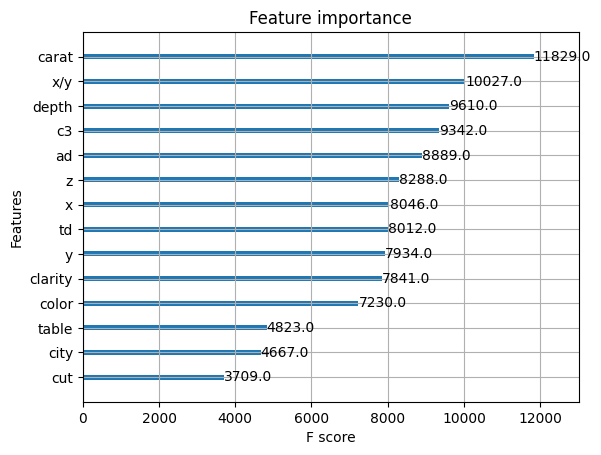

In [239]:
plt.figure(figsize=(10, 6))
ax = plot_importance(best_model, max_num_features=len(X.columns)+1)
plt.show()

In [240]:
rf_regressor = RandomForestRegressor()

# Define the parameter grid to search through
param_grid_rf = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2,3]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
X_nan = np.nan_to_num(X.astype(np.float32))
# Fit the GridSearchCV instance to the training data
grid_search.fit(X_nan, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best score found: ", best_score)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [ 0.1, 1, 10,]
}
logistic = LogisticRegression()
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid_lr, cv=3, n_jobs=None, verbose=2, scoring='neg_root_mean_squared_error')

# Fit the GridSearchCV instance to the training data
grid_search.fit(X_nan, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best score found: ", best_score)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\rjcol\.conda\envs\streamlit_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s


c:\Users\rjcol\.conda\envs\streamlit_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................................C=0.1, penalty=l2; total time= 2.3min
[CV] END ..................................C=0.1, penalty=l2; total time= 5.5min


KeyboardInterrupt: 

In [287]:
test = pd.read_csv('./data/src/diamonds_test.csv')
test['price'] = 0
submit_df = test[['id', 'price']]
test = test.drop(['id','price'], axis = 1)
test

,carat,cut,color,clarity,depth,table,x,y,z,city
0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam
1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat
2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly
3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly
4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam
...,...,...,...,...,...,...,...,...,...,...
13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,Amsterdam
13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,New York City
13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,Tel Aviv
13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,Surat


In [288]:
test.describe()

,carat,depth,table,x,y,z
count,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000,13485.000000
mean,0.798642,61.739095,57.490337,5.736454,5.739648,3.543474
std,0.469399,1.435310,2.237109,1.113671,1.128507,0.731005
min,0.200000,50.800000,51.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.730000,4.730000,2.920000
50%,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,1.040000,62.500000,59.000000,6.530000,6.530000,4.040000
max,5.010000,79.000000,73.000000,10.740000,31.800000,31.800000


In [289]:
X.describe()

,carat,depth,table,x,y,z,cut,color,clarity,city,x/y,td,ad
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.795712,61.749087,57.433731,5.729428,5.731641,3.537474,3.904783,4.400766,4.049388,1.036433,0.999352,0.930607,0.006125
std,0.468168,1.361600,2.176820,1.122433,1.114376,0.693746,1.117876,1.701260,1.648181,0.019357,0.008849,0.045753,0.000181
min,0.200000,57.457665,50.745527,2.356034,2.292869,1.445969,1.000000,1.000000,1.000000,1.000000,0.966818,0.791427,0.002847
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,1.031075,0.992593,0.898876,0.006046
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,4.000000,4.000000,4.000000,1.038843,0.995726,0.923825,0.006115
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000,5.000000,6.000000,5.000000,1.048770,1.006928,0.955519,0.006189
max,2.224338,66.048018,64.146739,9.102750,9.172768,5.628338,5.000000,7.000000,8.000000,1.069918,1.031968,1.070199,0.011228


In [290]:
data_labeling_test(test, ['cut', 'color', 'clarity','city'],dic2)

In [291]:
test[outlier_columns] = sub_outlyers(test[outlier_columns],3)

In [292]:
test['x/y'] = test.apply(lambda x : feature_xy(x['x'], x['y']), axis=1)
test['td'] = test.apply(lambda x : feature_xy(x['table'], x['depth']), axis=1)
test['ad'] = test.apply(lambda x : feature_ad(x['carat'],x['x'], x['y'], x['z']), axis=1)

In [293]:
#test = pd.concat([test, pd.get_dummies(test['city'], drop_first=True)], axis = 1).drop('city',axis = 1)

In [294]:
test[['x/y','td', 'ad']] = sub_outlyers(test[['x/y','td', 'ad']],3)

In [295]:
'''def filter_transform2(df,selected_features,target):
    data_df = df[selected_features]
    to_dummy = [feature for feature in selected_features if len(df[feature].unique()) < 15]
    for feature in to_dummy:
        dummies_df = pd.get_dummies(data_df[feature], prefix=feature, drop_first=True)
        data_df = pd.concat([data_df, dummies_df],axis=1).drop(feature, axis=1)   
    data_df = pd.concat([data_df.select_dtypes(exclude=['object']), df[target]], axis=1)
    return data_df'''

"def filter_transform2(df,selected_features,target):\n    data_df = df[selected_features]\n    to_dummy = [feature for feature in selected_features if len(df[feature].unique()) < 15]\n    for feature in to_dummy:\n        dummies_df = pd.get_dummies(data_df[feature], prefix=feature, drop_first=True)\n        data_df = pd.concat([data_df, dummies_df],axis=1).drop(feature, axis=1)   \n    data_df = pd.concat([data_df.select_dtypes(exclude=['object']), df[target]], axis=1)\n    return data_df"

In [296]:
test = test[X.columns]
test.to_csv('./data/clean/testdl123fexydatdso3x2.csv')

In [297]:
X_submit = test

In [298]:
price_list = best_model.predict(X_submit)

In [299]:
submit_df['price'] = 0
submit_df

,id,price
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
13480,13480,0
13481,13481,0
13482,13482,0
13483,13483,0


In [300]:
submit_df['price'] = price_list
submit_df['price']

0        2876.100830
1        5621.440430
2        9607.622070
3        4015.559570
4        1618.453613
            ...     
13480    1702.471558
13481    2498.168701
13482    3076.998779
13483    2097.655029
13484     799.293274
Name: price, Length: 13485, dtype: float32

In [301]:
submit_df.set_index('id')['price'].to_csv('./submissions/xgartl123gridtdso3x2.csv')

In [184]:
pickle.dump(best_model, open('./models/xgartdl123dlgridtdso3x2.sav', 'wb'))

In [59]:
loaded_model = pickle.load(open('./models/dl123dlgridtdso3.sav', 'rb'))
